In [41]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test_nolabel.csv')

## Exploración y limpieza del dataset

Empezamos haciendo una exploración del dataset. Para ello hemos probado la libreria `dtale`.

In [42]:
# import dtale
# dtale.show(train, open_browser=True)

In [ ]:
drop = ['LoanNr_ChkDgt', 'id', 'State']

Ahora, aseguramos que todas las variables categoricas son `object` y las numéricas son `int` o `float`, agrupamos datos y tratando de corregir los datos incorrectos.

In [44]:
train['ApprovalDate'] = pd.to_datetime(train['ApprovalDate'], format='%d-%b-%y')

train['NewExist'] = train['NewExist'].astype(str).replace({'0':'Unknown', '1':'New', '2':'Existing'})

train['FranchiseCode'] = train['FranchiseCode'].astype(str)
train['FranchiseCode'] = train['FranchiseCode'].apply(lambda x: 'No Franchise' if x in {'0', '1'} else 'Franchise')

train['UrbanRural'] = train['UrbanRural'].astype(str).replace({'0':'Unknown', '1':'Urban', '2':'Rural'})

train['RevLineCr'] = train['RevLineCr'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

train['LowDoc'] = train['LowDoc'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

train['DisbursementDate'] = pd.to_datetime(train['DisbursementDate'], format='%d-%b-%y')

train[['DisbursementGross', 'BalanceGross']] = train[['DisbursementGross', 'BalanceGross']].replace({r'\$': '', ',': ''}, regex=True).astype(float)

Lo mismo con el test

In [45]:
test['ApprovalDate'] = pd.to_datetime(test['ApprovalDate'], format='%d-%b-%y')

test['NewExist'] = test['NewExist'].astype(str).replace({'0':'Unknown', '1':'New', '2':'Existing'})

test['FranchiseCode'] = test['FranchiseCode'].astype(str)
test['FranchiseCode'] = test['FranchiseCode'].apply(lambda x: 'No Franchise' if x in {'0', '1'} else 'Franchise')

test['UrbanRural'] = test['UrbanRural'].astype(str).replace({'0':'Unknown', '1':'Urban', '2':'Rural'})

test['RevLineCr'] = test['RevLineCr'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

test['LowDoc'] = test['LowDoc'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

test['DisbursementDate'] = pd.to_datetime(test['DisbursementDate'], format='%d-%b-%y')

test[['DisbursementGross', 'BalanceGross']] = test[['DisbursementGross', 'BalanceGross']].replace({r'\$': '', ',': ''}, regex=True).astype(float)

Nuestro modelo dificilmente aprenderá directamente de las fechas. Transformaremos esta información en: año, trimestre

In [46]:
train['ApprovalYear'] = train['ApprovalDate'].dt.year
train['ApprovalQuarter'] = train['ApprovalDate'].dt.quarter
train['DisbursementYear'] = train['DisbursementDate'].dt.year
train['DisbursementQuarter'] = train['DisbursementDate'].dt.quarter
train['DaysToDisbursement'] = (train['DisbursementDate'] - train['ApprovalDate']).dt.days

train = train.drop(columns=['ApprovalDate', 'DisbursementDate'])

test['ApprovalYear'] = test['ApprovalDate'].dt.year
test['ApprovalQuarter'] = test['ApprovalDate'].dt.quarter
test['DisbursementYear'] = test['DisbursementDate'].dt.year
test['DisbursementQuarter'] = test['DisbursementDate'].dt.quarter
test['DaysToDisbursement'] = (test['DisbursementDate'] - test['ApprovalDate']).dt.days

test = test.drop(columns=['ApprovalDate', 'DisbursementDate'])

Vamos, también, a intentar sacar la información importante de los nombres. Al final estos no se borraron porque el modelo los parecía seguir teniendo en cuenta, con mejores resultados.

In [47]:
import re
name_counts = train['Name'].value_counts()

def categorize_company(name):
    name = str(name).upper()
    if pd.isna(name):
        return "Other"
    name = name.upper().strip()
    
    if re.search(r'\b(CORP(ORATION)?|INC(ORPORATED)?|CO|COMPANY)\b', name):
        return "Corporation"
    elif re.search(r'\b(L\.?L\.?C\.?|LIMITED|LTD|L\.?T\.?D\.?)\b', name):
        return "Limited"
    elif re.search(r'\b(CHURCH|FOUNDATION|ASSOCIATION|NONPROFIT|CLUB)\b', name):
        return "NonProfit"
    elif re.search(r'\b(CITY|COUNTY|STATE|SCHOOL|UNIVERSITY|GOV(ERNMENT)?|BOARD)\b', name):
        return "Government"
    else:
        return "Other"
    
def refine_corporation(name):
    name = str(name).upper()
    if "CORP" in name:
        return "CORP"
    elif "INC" in name:
        return "INC"
    elif "CO" in name:
        return "CO"
    elif "COMPANY" in name:
        return "COMPANY"
    else:
        return "Other"
    
def refine_limited(name):
    name = str(name).upper()
    if "LLC" in name:
        return "LLC"
    elif "LTD" in name:
        return "LTD"
    elif "LIMITED" in name:
        return "LIMITED"
    else:
        return "Other"

train['CompanyType'] = train['Name'].apply(categorize_company)
train['CorpType'] = train.apply(lambda row: refine_corporation(row['Name']) if row['CompanyType'] == 'Corporation' else 'Not_Corp', axis=1)
train['LtdType'] = train.apply(lambda row: refine_limited(row['Name']) if row['CompanyType'] == 'Limited' else 'Not_Ltd', axis=1)

test['CompanyType'] = test['Name'].apply(categorize_company)
test['CorpType'] = test.apply(lambda row: refine_corporation(row['Name']) if row['CompanyType'] == 'Corporation' else 'Not_Corp', axis=1)
test['LtdType'] = test.apply(lambda row: refine_limited(row['Name']) if row['CompanyType'] == 'Limited' else 'Not_Ltd', axis=1)

# train = train.drop(columns='Name')
# test = test.drop(columns='Name')

Vamos a agrupar tambien la variable ciudad

In [48]:
contador_ciudades = train['City'].value_counts()
umbral = 60
otras = contador_ciudades[contador_ciudades < umbral].index
train['City'] = train['City'].replace(otras, 'OTHER_CITY')
test['City'] = test['City'].replace(otras, 'OTHER_CITY')

In [49]:
cat_features = train.select_dtypes(include=['object']).columns.tolist()
cat_features = list(set(cat_features) - set(drop))
for col in cat_features:
    train[col] = train[col].astype(str).fillna("Unknown")
    test[col] = test[col].astype(str).fillna("Unknown")

In [50]:
# train.dtypes
# train.isna().sum()
# test.dtypes
# test.isna().sum()

## Idea

Si los nombres contienen algo de información que no somos capaz de extraer, quizá un aprendizaje no supervisado sí... Luego, en realidad no mejoro, pero nos será util para otros modelos.

In [51]:
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import KMeans
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

# n_clusters = 10
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# train['Name'] = train['Name'].fillna('').str.upper().str.strip()
# X_embed = model_sbert.encode(train['Name'].tolist(), show_progress_bar=True)
# train['Cluster'] = kmeans.fit_predict(X_embed)

# test['Name'] = test['Name'].fillna('').str.upper().str.strip()
# X_embed_test = model_sbert.encode(test['Name'].tolist(), show_progress_bar=True)
# test['Cluster'] = kmeans.predict(X_embed_test)

# train['Cluster'] = train['Cluster'].astype(str)
# test['Cluster'] = test['Cluster'].astype(str)


# train['Bank'] = train['Bank'].fillna('').str.upper().str.strip()
# X_embed_bank = model_sbert.encode(train['Bank'].tolist(), show_progress_bar=True)
# train['Cluster-Bank'] = kmeans.fit_predict(X_embed_bank)

# test['Bank'] = test['Bank'].fillna('').str.upper().str.strip()
# X_embed_bank_test = model_sbert.encode(test['Bank'].tolist(), show_progress_bar=True)
# test['Cluster-Bank'] = kmeans.predict(X_embed_bank_test)

# train['Cluster-Bank'] = train['Cluster-Bank'].astype(str)
# test['Cluster-Bank'] = test['Cluster-Bank'].astype(str)

# train = train.drop(columns=['Name', 'Bank'])
# test = test.drop(columns=['Name', 'Bank'])

In [52]:
# cat_features = train.select_dtypes(include=['object']).columns.tolist()
# cat_features = list(set(cat_features) - set(drop))
# for col in cat_features:
#     train[col] = train[col].astype(str).fillna("Unknown")
#     test[col] = test[col].astype(str).fillna("Unknown")

## CatBoost

In [53]:
X = train.drop(drop + ['Accept'], axis=1)
y = train['Accept']

Como nuestro dataset no esta balanceado, debemos corregirlo:

In [54]:
from collections import Counter

class_counts = Counter(y)
total = sum(class_counts.values())
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}
class_weights

{1: 0.6007945695643022, 0: 2.9802923518663533}

Fold 1: F1 = 0.8489
Fold 2: F1 = 0.8516
Fold 3: F1 = 0.8427
Fold 4: F1 = 0.8442
Fold 5: F1 = 0.8367
Fold 6: F1 = 0.8398
Fold 7: F1 = 0.8432


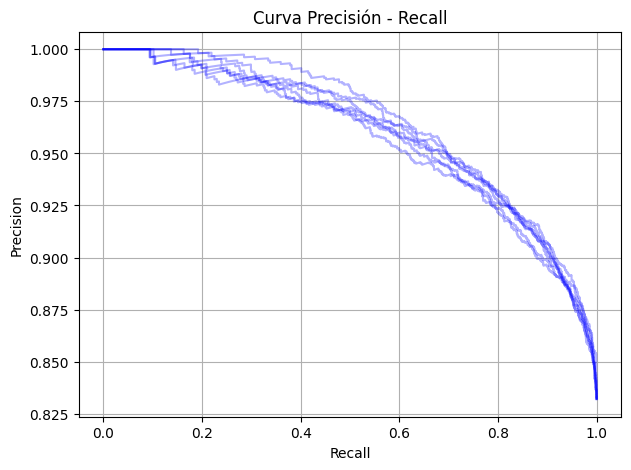


F1 promedio: 0.8439 (+/- 0.0047)


In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

f1_scores = []
models = []

plt.figure(figsize=(7,5))

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(
        iterations=800,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=5,
        eval_metric='F1',
        class_weights=[class_weights[0], class_weights[1]],
        random_state=42,
        cat_features=cat_features,
        verbose=False,
        early_stopping_rounds=125 ### CAMBIO IMPORTANTE
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    models.append(model)
    
    preds = model.predict(X_val)
    score = f1_score(y_val, preds)
    f1_scores.append(score)
    
    print(f'Fold {fold+1}: F1 = {score:.4f}')

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

    plt.plot(recall, precision, color='blue', alpha=0.3)

plt.title(f"Curva Precisión - Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

print()
print(f'F1 promedio: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})')

In [56]:
# predictions_best_model = models[ np.argmax(f1_scores) ].predict(test.drop(drop, axis=1))
# submission = pd.DataFrame({
#     'id': test['id'],
#     'Accept': predictions_best_model
# })
# submission.to_csv('catboost_best_model.csv', index=False)

In [57]:
predictions_ensemble = np.array([model.predict(test.drop(drop, axis=1)) for model in models])
final_preds = [1 if np.sum(predictions_ensemble[:, i]) > (predictions_ensemble.shape[0] / 2) else 0 for i in range(predictions_ensemble.shape[1])]
submission = pd.DataFrame({
    'id': test['id'],
    'Accept': final_preds
})
submission.to_csv('catboost_ensemble.csv', index=False)

## CatBoost Con Grid

In [58]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import make_scorer, f1_score

# cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# f1_scorer = make_scorer(f1_score)

# model = CatBoostClassifier(
#     eval_metric='F1',
#     cat_features=cat_features,
#     class_weights=[class_weights[0], class_weights[1]],
#     verbose=False
# )

# param_grid = {
#     'iterations': [500, 800],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'l2_leaf_reg': [1, 3, 5]
# }

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )
# grid_search.fit(X, y)

# print("Mejores parámetros:", grid_search.best_params_)
# print("Mejor F1:", grid_search.best_score_)

In [59]:
# best_model = grid_search.best_estimator_
# predictions_best_model = best_model.predict(test.drop(drop, axis=1))
# submission = pd.DataFrame({
#     'id': test['id'],
#     'Accept': predictions_best_model
# })
# submission.to_csv('catboost_grid_search.csv', index=False)

In [60]:
# results_df = pd.DataFrame(grid_search.cv_results_)
# results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
# results_df = results_df.sort_values(by='mean_test_score', ascending=False)
# results_df.set_index('rank_test_score', inplace=True)
# results_df.loc[9].params